In [ ]:
import gdown
import zipfile
import os
# Google Drive file ID
file_id = '1QKokG7U-LMFklrB8xgt9JvDfWKDFkYyb'

# Download the file using gdown
download_url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'downloaded_file.zip'
gdown.download(download_url, output_file, quiet=False)

# Unzipping the downloaded file
with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

# Optionally, remove the zip file after extraction
os.remove(output_file)

print("File downloaded and extracted successfully.")

Downloading...
From: https://drive.google.com/uc?id=1QKokG7U-LMFklrB8xgt9JvDfWKDFkYyb
To: /content/downloaded_file.zip
100%|██████████| 12.7M/12.7M [00:00<00:00, 12.9MB/s]

File downloaded and extracted successfully.


In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5i_0gew_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5i_0gew_
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done


In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog

# Unregister the dataset if it exists
if "my_dataset_train" in MetadataCatalog:
    MetadataCatalog.remove("my_dataset_train")
if "my_dataset_val" in MetadataCatalog:
    MetadataCatalog.remove("my_dataset_val")

# Register your dataset (replace 'my_dataset' with your dataset name)
register_coco_instances("my_dataset_train", {}, "/content/extracted_files/dataset/train/annotations/instances_default.json", "/content/extracted_files/dataset/train/images")
register_coco_instances("my_dataset_val", {}, "/content/extracted_files/dataset/valid/annotations/instances_default.json", "/content/extracted_files/dataset/valid/images")

# Load metadata
metadata = MetadataCatalog.get("my_dataset_train")

# Define the flip map (in your case, no keypoint flip may be necessary)
keypoint_flip_map = []

# Register your dataset and then set the metadata
MetadataCatalog.get("my_dataset_train").set(keypoint_flip_map=keypoint_flip_map)
MetadataCatalog.get("my_dataset_val").set(keypoint_flip_map=keypoint_flip_map)


# Define the names of the keypoints you want to detect (update this to match your dataset)
keypoint_names = ["pupil"]

# Add the keypoint information to the dataset metadata
metadata = MetadataCatalog.get("my_dataset_train")
metadata.set(keypoint_names=keypoint_names)


namespace(name='my_dataset_train',
          json_file='/content/extracted_files/dataset/train/annotations/instances_default.json',
          image_root='/content/extracted_files/dataset/train/images',
          evaluator_type='coco',
          keypoint_flip_map=[],
          keypoint_names=['pupil'])

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Load configuration and modify it for keypoint detection
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

# Number of keypoints to detect (update this to match your dataset)
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 1  # Set this based on your dataset

# Set the weights to COCO pre-trained model and initialize
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

# Specify training settings
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 2500  # Adjust based on your dataset size
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Increase if using larger GPU
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Set to 1 if it's a single class (like pupil detection)
cfg.MODEL.DEVICE = "cuda"  # Use "cpu" if no GPU available
cfg.TEST.EVAL_PERIOD = 500  # How often to evaluate during training

# Output directory
cfg.OUTPUT_DIR = "./output"

# Train the model
from detectron2.engine import DefaultTrainer
import os

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[10/02 04:18:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
roi_heads.keypoint_head.score_lowres.{bias, weight}


[10/02 04:18:38 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consid

[10/02 04:18:45 d2.utils.events]:  eta: 0:20:50  iter: 19  total_loss: 11.34  loss_cls: 0.6184  loss_box_reg: 0.09672  loss_keypoint: 8.108  loss_rpn_cls: 1.745  loss_rpn_loc: 0.2004    time: 0.3180  last_time: 0.3620  data_time: 0.0305  last_data_time: 0.0250   lr: 1.9981e-05  max_mem: 2397M
[10/02 04:18:52 d2.utils.events]:  eta: 0:22:46  iter: 39  total_loss: 8.624  loss_cls: 0.19  loss_box_reg: 0.252  loss_keypoint: 8.001  loss_rpn_cls: 0.02193  loss_rpn_loc: 0.1258    time: 0.3438  last_time: 0.3969  data_time: 0.0151  last_data_time: 0.0133   lr: 3.9961e-05  max_mem: 2399M
[10/02 04:18:59 d2.utils.events]:  eta: 0:23:07  iter: 59  total_loss: 8.459  loss_cls: 0.1605  loss_box_reg: 0.2936  loss_keypoint: 7.827  loss_rpn_cls: 0.01822  loss_rpn_loc: 0.1163    time: 0.3498  last_time: 0.3378  data_time: 0.0144  last_data_time: 0.0074   lr: 5.9941e-05  max_mem: 2399M
[10/02 04:19:07 d2.utils.events]:  eta: 0:23:28  iter: 79  total_loss: 7.324  loss_cls: 0.1414  loss_box_reg: 0.2727  l

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[10/02 04:22:00 d2.utils.events]:  eta: 0:22:30  iter: 519  total_loss: 6.437  loss_cls: 0.07698  loss_box_reg: 0.3292  loss_keypoint: 5.999  loss_rpn_cls: 0.01461  loss_rpn_loc: 0.071    time: 0.3875  last_time: 0.3738  data_time: 0.0105  last_data_time: 0.0073   lr: 0.00051948  max_mem: 2426M
[10/02 04:22:09 d2.utils.events]:  eta: 0:22:28  iter: 539  total_loss: 6.443  loss_cls: 0.06909  loss_box_reg: 0.2628  loss_keypoint: 5.991  loss_rpn_cls: 0.01013  loss_rpn_loc: 0.08382    time: 0.3889  last_time: 0.3955  data_time: 0.0137  last_data_time: 0.0175   lr: 0.00053946  max_mem: 2426M
[10/02 04:22:17 d2.utils.events]:  eta: 0:22:22  iter: 559  total_loss: 6.35  loss_cls: 0.05957  loss_box_reg: 0.2927  loss_keypoint: 5.923  loss_rpn_cls: 0.006982  loss_rpn_loc: 0.07352    time: 0.3899  last_time: 0.4425  data_time: 0.0149  last_data_time: 0.0294   lr: 0.00055944  max_mem: 2426M
[10/02 04:22:25 d2.utils.events]:  eta: 0:22:15  iter: 579  total_loss: 6.524  loss_cls: 0.0593  loss_box_re

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[10/02 04:25:25 d2.utils.events]:  eta: 0:19:51  iter: 1019  total_loss: 6.38  loss_cls: 0.06219  loss_box_reg: 0.2557  loss_keypoint: 5.921  loss_rpn_cls: 0.007685  loss_rpn_loc: 0.08651    time: 0.3985  last_time: 0.4040  data_time: 0.0116  last_data_time: 0.0067   lr: 0.001  max_mem: 2427M
[10/02 04:25:34 d2.utils.events]:  eta: 0:19:46  iter: 1039  total_loss: 5.78  loss_cls: 0.04951  loss_box_reg: 0.2257  loss_keypoint: 5.388  loss_rpn_cls: 0.007382  loss_rpn_loc: 0.08355    time: 0.3987  last_time: 0.4404  data_time: 0.0112  last_data_time: 0.0155   lr: 0.001  max_mem: 2427M
[10/02 04:25:42 d2.utils.events]:  eta: 0:19:40  iter: 1059  total_loss: 6.519  loss_cls: 0.04983  loss_box_reg: 0.2569  loss_keypoint: 6.052  loss_rpn_cls: 0.0127  loss_rpn_loc: 0.06991    time: 0.3987  last_time: 0.3713  data_time: 0.0110  last_data_time: 0.0063   lr: 0.001  max_mem: 2427M
[10/02 04:25:50 d2.utils.events]:  eta: 0:19:33  iter: 1079  total_loss: 6.389  loss_cls: 0.04839  loss_box_reg: 0.2509

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[10/02 04:28:53 d2.utils.events]:  eta: 0:16:59  iter: 1519  total_loss: 5.96  loss_cls: 0.04187  loss_box_reg: 0.2138  loss_keypoint: 5.596  loss_rpn_cls: 0.008562  loss_rpn_loc: 0.06767    time: 0.4034  last_time: 0.4549  data_time: 0.0161  last_data_time: 0.0070   lr: 0.001  max_mem: 2430M
[10/02 04:29:01 d2.utils.events]:  eta: 0:16:50  iter: 1539  total_loss: 5.829  loss_cls: 0.06339  loss_box_reg: 0.2259  loss_keypoint: 5.439  loss_rpn_cls: 0.004915  loss_rpn_loc: 0.07055    time: 0.4034  last_time: 0.4612  data_time: 0.0101  last_data_time: 0.0296   lr: 0.001  max_mem: 2430M
[10/02 04:29:09 d2.utils.events]:  eta: 0:16:41  iter: 1559  total_loss: 5.989  loss_cls: 0.04732  loss_box_reg: 0.225  loss_keypoint: 5.566  loss_rpn_cls: 0.01283  loss_rpn_loc: 0.0682    time: 0.4034  last_time: 0.3571  data_time: 0.0170  last_data_time: 0.0063   lr: 0.001  max_mem: 2430M
[10/02 04:29:17 d2.utils.events]:  eta: 0:16:33  iter: 1579  total_loss: 5.897  loss_cls: 0.048  loss_box_reg: 0.2159  

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[10/02 04:32:18 d2.utils.events]:  eta: 0:13:37  iter: 2019  total_loss: 5.824  loss_cls: 0.04703  loss_box_reg: 0.1978  loss_keypoint: 5.509  loss_rpn_cls: 0.007473  loss_rpn_loc: 0.05701    time: 0.4053  last_time: 0.4276  data_time: 0.0146  last_data_time: 0.0265   lr: 0.001  max_mem: 2430M
[10/02 04:32:26 d2.utils.events]:  eta: 0:13:28  iter: 2039  total_loss: 5.602  loss_cls: 0.03741  loss_box_reg: 0.1789  loss_keypoint: 5.292  loss_rpn_cls: 0.007385  loss_rpn_loc: 0.06653    time: 0.4052  last_time: 0.4332  data_time: 0.0143  last_data_time: 0.0176   lr: 0.001  max_mem: 2430M
[10/02 04:32:35 d2.utils.events]:  eta: 0:13:20  iter: 2059  total_loss: 5.905  loss_cls: 0.05193  loss_box_reg: 0.2024  loss_keypoint: 5.566  loss_rpn_cls: 0.00858  loss_rpn_loc: 0.06561    time: 0.4054  last_time: 0.4724  data_time: 0.0162  last_data_time: 0.0067   lr: 0.001  max_mem: 2430M
[10/02 04:32:43 d2.utils.events]:  eta: 0:13:12  iter: 2079  total_loss: 5.567  loss_cls: 0.05126  loss_box_reg: 0.1

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[10/02 04:35:45 d2.utils.events]:  eta: 0:10:08  iter: 2519  total_loss: 5.405  loss_cls: 0.04228  loss_box_reg: 0.2199  loss_keypoint: 5.066  loss_rpn_cls: 0.003183  loss_rpn_loc: 0.06522    time: 0.4067  last_time: 0.4648  data_time: 0.0117  last_data_time: 0.0062   lr: 0.001  max_mem: 2431M
[10/02 04:35:53 d2.utils.events]:  eta: 0:10:01  iter: 2539  total_loss: 5.47  loss_cls: 0.03938  loss_box_reg: 0.2017  loss_keypoint: 5.139  loss_rpn_cls: 0.005568  loss_rpn_loc: 0.05511    time: 0.4068  last_time: 0.3317  data_time: 0.0139  last_data_time: 0.0160   lr: 0.001  max_mem: 2431M
[10/02 04:36:01 d2.utils.events]:  eta: 0:09:53  iter: 2559  total_loss: 5.46  loss_cls: 0.0363  loss_box_reg: 0.1677  loss_keypoint: 5.196  loss_rpn_cls: 0.007025  loss_rpn_loc: 0.05951    time: 0.4068  last_time: 0.4766  data_time: 0.0142  last_data_time: 0.0170   lr: 0.001  max_mem: 2431M
[10/02 04:36:10 d2.utils.events]:  eta: 0:09:45  iter: 2579  total_loss: 5.192  loss_cls: 0.03694  loss_box_reg: 0.143

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[10/02 04:39:14 d2.utils.events]:  eta: 0:06:46  iter: 3019  total_loss: 5.337  loss_cls: 0.04278  loss_box_reg: 0.1728  loss_keypoint: 5.01  loss_rpn_cls: 0.005415  loss_rpn_loc: 0.06685    time: 0.4084  last_time: 0.4405  data_time: 0.0137  last_data_time: 0.0133   lr: 0.001  max_mem: 2431M
[10/02 04:39:22 d2.utils.events]:  eta: 0:06:38  iter: 3039  total_loss: 5.344  loss_cls: 0.043  loss_box_reg: 0.1458  loss_keypoint: 5.095  loss_rpn_cls: 0.009824  loss_rpn_loc: 0.06183    time: 0.4085  last_time: 0.3716  data_time: 0.0139  last_data_time: 0.0060   lr: 0.001  max_mem: 2431M
[10/02 04:39:31 d2.utils.events]:  eta: 0:06:29  iter: 3059  total_loss: 5.408  loss_cls: 0.03868  loss_box_reg: 0.1612  loss_keypoint: 5.136  loss_rpn_cls: 0.005859  loss_rpn_loc: 0.0487    time: 0.4085  last_time: 0.3827  data_time: 0.0114  last_data_time: 0.0160   lr: 0.001  max_mem: 2431M
[10/02 04:39:39 d2.utils.events]:  eta: 0:06:21  iter: 3079  total_loss: 5.386  loss_cls: 0.03775  loss_box_reg: 0.1812

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[10/02 04:42:43 d2.utils.events]:  eta: 0:03:21  iter: 3519  total_loss: 5.194  loss_cls: 0.04201  loss_box_reg: 0.1682  loss_keypoint: 4.936  loss_rpn_cls: 0.006486  loss_rpn_loc: 0.05602    time: 0.4096  last_time: 0.4237  data_time: 0.0155  last_data_time: 0.0131   lr: 0.001  max_mem: 2431M
[10/02 04:42:51 d2.utils.events]:  eta: 0:03:12  iter: 3539  total_loss: 5.309  loss_cls: 0.0328  loss_box_reg: 0.1775  loss_keypoint: 5.016  loss_rpn_cls: 0.007432  loss_rpn_loc: 0.05752    time: 0.4096  last_time: 0.3497  data_time: 0.0106  last_data_time: 0.0067   lr: 0.001  max_mem: 2431M
[10/02 04:42:59 d2.utils.events]:  eta: 0:03:04  iter: 3559  total_loss: 5.058  loss_cls: 0.03154  loss_box_reg: 0.1472  loss_keypoint: 4.837  loss_rpn_cls: 0.003093  loss_rpn_loc: 0.05835    time: 0.4097  last_time: 0.4248  data_time: 0.0173  last_data_time: 0.0067   lr: 0.001  max_mem: 2431M
[10/02 04:43:08 d2.utils.events]:  eta: 0:02:55  iter: 3579  total_loss: 5  loss_cls: 0.03966  loss_box_reg: 0.1564 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[10/02 04:56:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

tensor(0.0476)
tensor(0.0522)


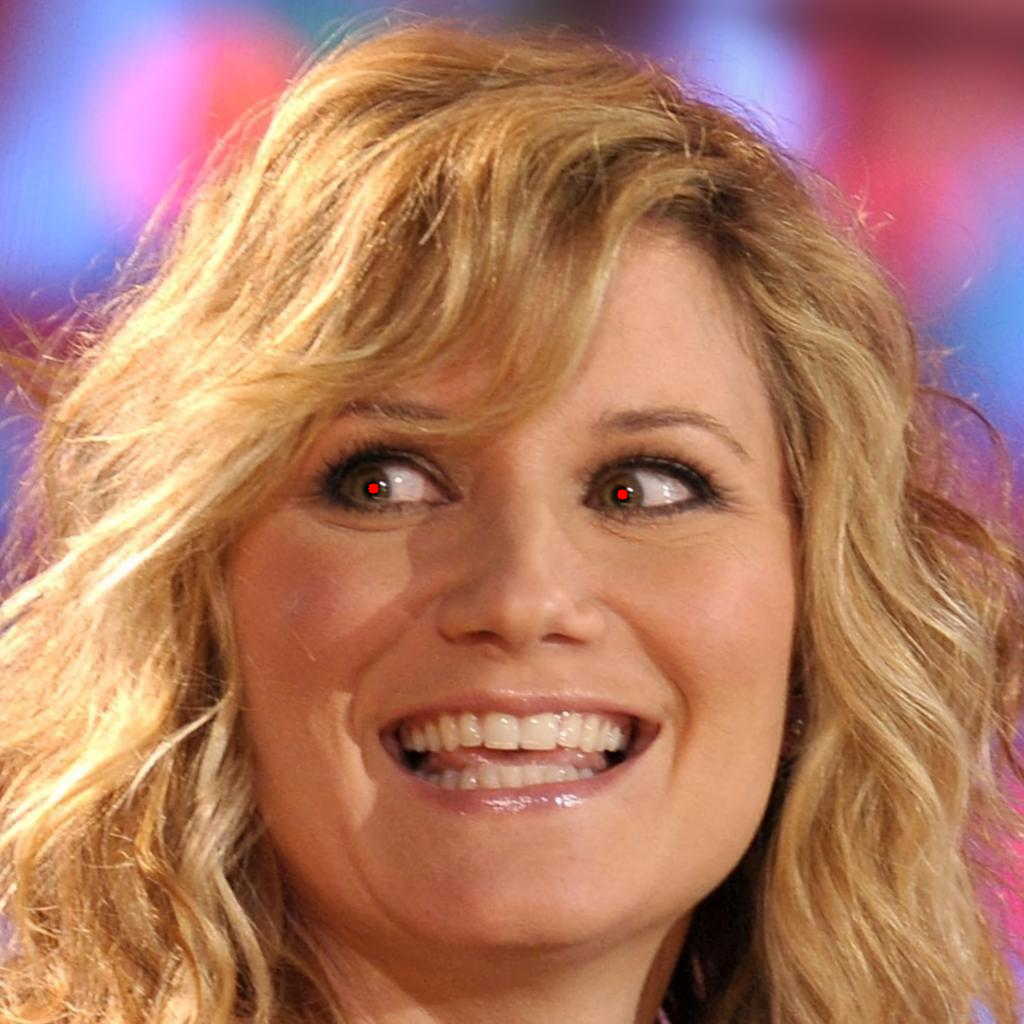

In [ ]:
from detectron2.engine import DefaultPredictor
import cv2
import torch
import os

# Load trained model weights for inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set a threshold for predictions
predictor = DefaultPredictor(cfg)

# Inference on an image
image_path = "/content/extracted_files/dataset/valid/images/6220_jpg.rf.1ec96e8b65d719fc2e081597ebe5766e.jpg"
image = cv2.imread(image_path)
outputs = predictor(image)

# Extract keypoints from the predictions
instances = outputs["instances"].to("cpu")
keypoints = instances.pred_keypoints if instances.has("pred_keypoints") else None

# Visualize keypoints (x, y positions) using OpenCV
if keypoints is not None:
    for kp_set in keypoints:
        for kp in kp_set:
            x, y, conf = kp
            # if conf > 0.5:  # Only draw keypoints with confidence greater than 0.5
                # Draw a small circle on each keypoint (x, y)
            cv2.circle(image, (int(x), int(y)), radius=5, color=(0, 0, 255), thickness=-1)

# Display the image with keypoints using OpenCV
cv2_imshow(image)




[10/02 04:50:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

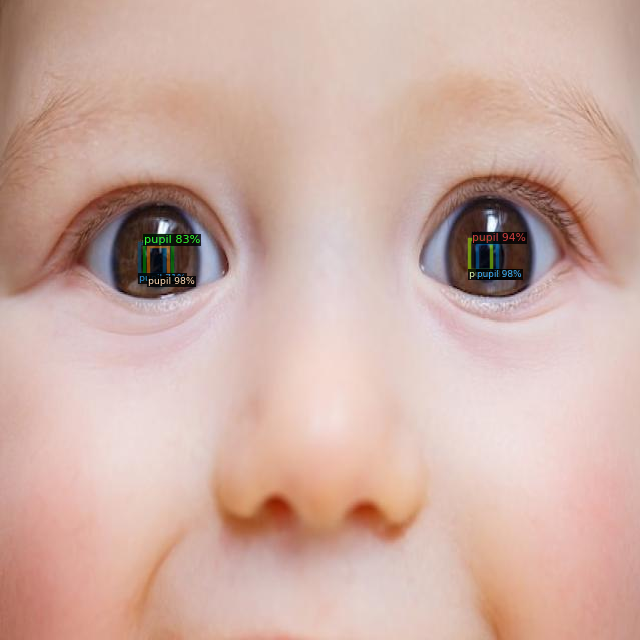

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
import cv2
from google.colab.patches import cv2_imshow

# Load trained model weights for inference
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set a threshold for predictions
predictor = DefaultPredictor(cfg)

# Inference on an image
image = cv2.imread("/content/extracted_files/dataset/test/images/01_jpg.rf.5027281464f48b075e4542140c371c62.jpg")
outputs = predictor(image)

# Remove the bounding boxes by setting them to None
instances = outputs["instances"].to("cpu")

# Visualize keypoints only
v = Visualizer(image[:, :, ::-1], metadata=metadata)
out = v.draw_instance_predictions(instances)
cv2_imshow(out.get_image()[:, :, ::-1])
